In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
from sklearn.covariance import EmpiricalCovariance
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_score as clust_score
from sklearn.preprocessing import StandardScaler
from scipy import stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
from ipywidgets import interact

# needs to find the library of functions
sys.path.append('../../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# a double percentage sign indicates a magic function. in this case, now we are writing this cell in javascript.

In [5]:
NOTEBOOK_NAME = 'decoding_licks'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [7]:
folder = './autorestore/preprocessing'
for var in ('time_ax', 'traces', 'events', 'cycles', 'licks',
            'is_rewardt', 'is_CSmt', 'is_sht', 'CYCLE_START', 'CS_DURATION'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))

In [8]:
lick_counts = []
for s, e in zip(time_ax, time_ax[1:]):
    lick_counts.append(np.sum((licks>=s) * (licks<e)))
lick_counts = np.r_[0, lick_counts]

In [9]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut, cross_val_predict

In [10]:
lr = LassoCV()
cv = LeaveOneGroupOut()
n_splits = 10
groups = np.repeat(range(n_splits), events.shape[0]/n_splits+1)
groups = groups[:events.shape[0]]
smooth_win = 10  # samples
x = np.convolve(lick_counts, 1.*np.ones(smooth_win)/smooth_win, mode='same')
lick_counts_pred = cross_val_predict(lr, events, x, cv=cv.split(events, x, groups=groups))
scores = cross_val_score(lr, events, x, cv=cv.split(events, x, groups=groups))

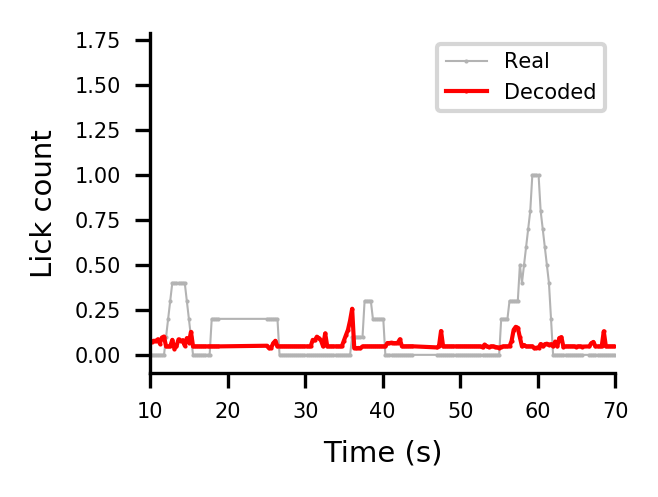

In [11]:
dt = 10
fig, ax = pl.subplots(1, 1, figsize=(2, 1.5))
ax.plot(time_ax, x, 'o-', lw=0.5, color='0.7', mew=0, ms=1)
ax.plot(time_ax, lick_counts_pred, 'o-', lw=1, color='r', mew=0, ms=1)
ax.set_xlim(0+dt, 60+dt)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Lick count')
ax.legend(['Real', 'Decoded'])

In [12]:
coeffs = []
lr = LassoCV()
for train, test in cv.split(events, x, groups=groups):
    coeffs.append(lr.fit(events[train], x[train]).coef_)

In [13]:
coeffs = np.r_[coeffs]

In [14]:
nonlick_cells = coeffs.mean(0)<=np.percentile(coeffs.mean(0), 10)
onlylick_cells = coeffs.mean(0)>np.percentile(coeffs.mean(0), 90)

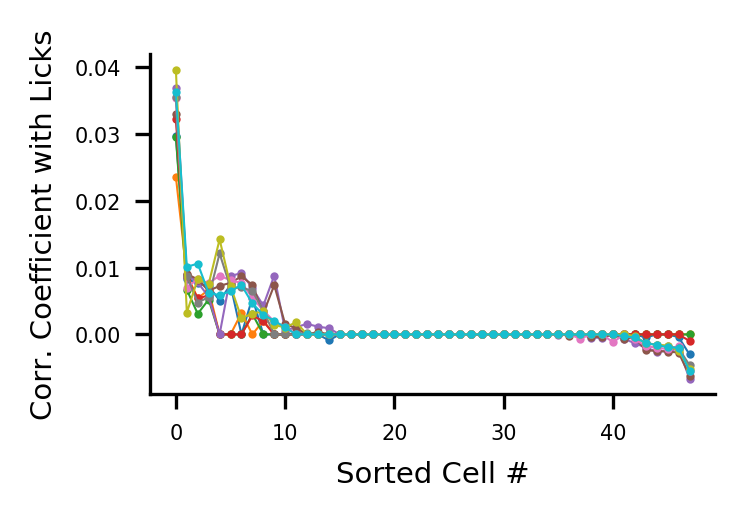

In [15]:
pl.plot(coeffs.T[np.argsort(coeffs.mean(0))[::-1]], 'o-', mew=0, ms=2, lw=0.5);
pl.xlabel('Sorted Cell #')
pl.ylabel('Corr. Coefficient with Licks')

In [16]:
lr = LassoCV()
lick_counts_pred_nonlicks = cross_val_predict(lr, events[:, nonlick_cells], x, cv=cv.split(events, x, groups=groups))
scores_nonlicks = cross_val_score(lr, events[:, nonlick_cells], x, cv=cv.split(events, x, groups=groups))

lick_counts_pred_onlylicks = cross_val_predict(lr, events[:, onlylick_cells], x, cv=cv.split(events, x, groups=groups))
scores_onlylicks = cross_val_score(lr, events[:, onlylick_cells], x, cv=cv.split(events, x, groups=groups))

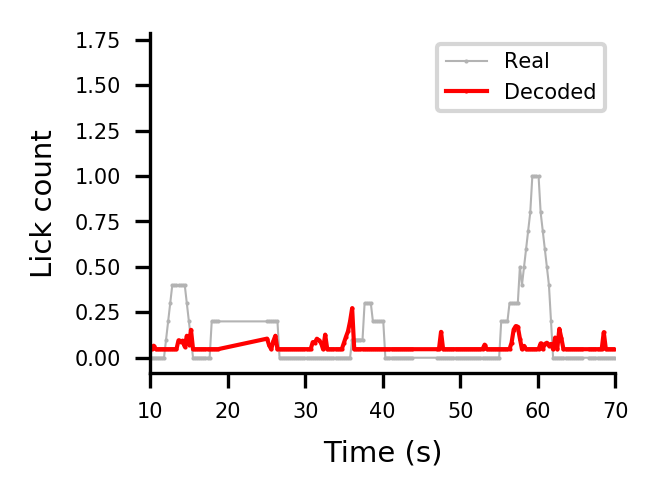

In [17]:
dt = 10
fig, ax = pl.subplots(1, 1, figsize=(2, 1.5))
ax.plot(time_ax, x, 'o-', lw=0.5, color='0.7', mew=0, ms=1)
ax.plot(time_ax, lick_counts_pred_onlylicks, 'o-', lw=1, color='r', mew=0, ms=1)
ax.set_xlim(0+dt, 60+dt)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Lick count')
ax.legend(['Real', 'Decoded'])

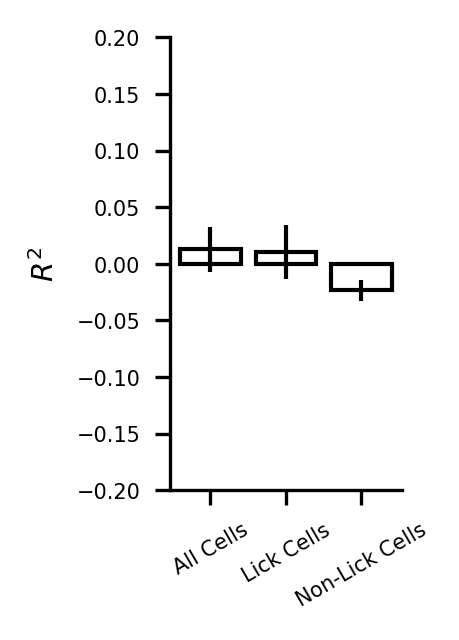

In [18]:
fig, ax = pl.subplots(1, 1, figsize=(1, 2))
pt.plot_bars([scores, scores_onlylicks, scores_nonlicks], stderr=True, ax=ax)
ax.set_ylim(-.2, 0.2)
ax.set_ylabel('$R^2$')
ax.set_xticks(range(3))
ax.set_xticklabels(['All Cells', 'Lick Cells', 'Non-Lick Cells'], rotation=30)

In [19]:
events_proj = np.ones_like(events)
lr = LassoCV()
for train, test in cv.split(events, x, groups=groups):
    lr.fit(events[train], x[train])
    a = events_proj[:, ~nonlick_cells]
    a[test] = np.r_[[np.nan_to_num((l-lr.intercept_)/lr.coef_[~nonlick_cells])
                                           for l in lick_counts[test]]]
    events_proj[:, ~nonlick_cells] = a

/home/fabios/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide


In [20]:
events_res = np.clip(events_proj, 0, 1e4)-events

In [21]:
from sklearn.svm import LinearSVC

In [22]:
folder = './autorestore/decoding_odors_rw_csm/'
for var in ('labels',): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))

In [23]:
delta_t0 = 1

t_start0 = -3  # sec
t_stop0 = 10  # sec

patterns_tb = np.r_[[ut.extract_activity(time_ax, events_res, cycles, CYCLE_START, i*delta_t0, (i+1)*delta_t0,
                                      offset=t_start0)
                     for i in xrange(int((t_stop0-t_start0)/delta_t0))]]

decodor = LinearSVC()

# which_trials = labels>1  # only flower and banana
which_trials = [True] * len(labels)  # all odors and air
# which_trials = (labels==1) * (labels==5)  # only air and banana

labels_tb = np.r_[[[l]*patterns_tb.shape[0] for l in labels]].T
from sklearn.model_selection import cross_val_score
scores = []
for i, (p, l) in enumerate(zip(patterns_tb, labels_tb)):
    # for every time bin
    scores.append(cross_val_score(decodor, p[which_trials], l[which_trials], cv=5))
# scores_tb3.append(scores_tb3)
scores = np.r_[scores]

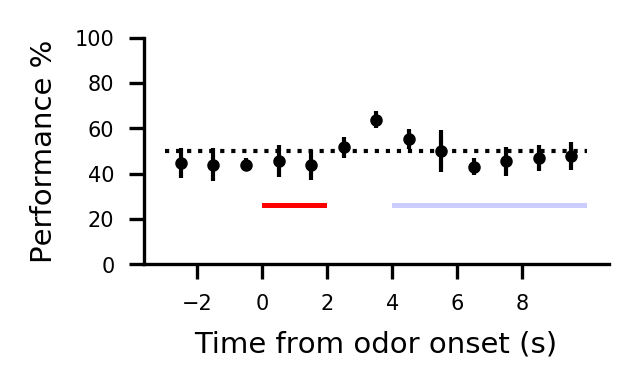

In [24]:
fig, ax = pl.subplots(1, 1, figsize=(2, 1))

t = np.arange(t_start0, t_stop0, delta_t0)
# ax.fill_between(t+np.diff(t)[0]/2.,
#                 (scores.mean(1) + np.std(scores, 1))*100,
#                 (scores.mean(1) - np.std(scores, 1))*100,
#                 lw=0, color='0.8')
ax.plot(t+np.diff(t)[0]/2., scores.mean(1)*100, 'ko', lw=.5, zorder=19,ms=2)
m = scores.mean(1)*100
s = np.std(scores, 1)*100 / np.sqrt(scores.shape[1]-1)
ax.errorbar(t+np.diff(t)[0]/2., m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
ax.set_ylim(0, 100)
ax.set_xticks(np.arange(t_start0+1, t_stop0, 2))
ax.hlines(50, t_start0, t_stop0, color='k', lw=1, linestyles='dotted')
# ax.step(t, scores_tb3.mean(1), lw=.5, zorder=19, where='post')
# ax.vlines(t, 0, 100, zorder=0, lw=0.5, color='0.8')
pt.nicer_plot(ax)
ax.set_xlabel('Time from odor onset (s)')
ax.set_ylabel('Performance %')
pt.plot_period_bar(ax, 25, start_end=(0, 2), color='r', delta_y=2)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
pt.plot_period_bar(ax, 25, start_end=(4, 10), color=(0.8, 0.8, 1), delta_y=2)


# fig.savefig('img/proposal_decoding_timebased.svg')

In [25]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
